# Modelling patch-clamp experiments: electronic compensation

In the [last notebook](./artefacts-1-modelling-patch-clamp.ipynb), we introduced an electrical schematic that can serve as a model of the patch-clamp set up, with distortions by leak, offsets, and unwanted capacitances.
To compensate for these unwanted effects, patch-clamp amplifiers contain special circuitry.
In this notebook we extend our model to include the effects of these compensations, as modelled in [Lei et al., 2020](https://doi.org/10.1098/rsta.2019.0348).

We will deal mostly with _transient_ distortions of the recorded output signal, which we call _artefacts_, and with transient differences between the true and intended membrane potential, which are an example of _imperfect control_.
These terms, and general strategies for dealing with their effects, are discussed in [Appendix H](./appendix-H-strategies.ipynb).
Stochastic and periodic noise are not discussed here, but a brief discussion is given in [Appendix I](./appendix-I-inspecting-noise.ipynb).

## Zeroing and the liquid junction potential ($E_\text{off}$)

In the last notebook we introduced $E_\text{off}$, which represents the sum of various voltage offsets that are incurred in the experimental setup.
This offset is usually corrected by a dial or a digital control that allows the experimenter to subtract an equal offset $-E_\text{off}^*$.
To allow for the idea that this correction is imperfect, either because it was set imperfectly or because $E_\text{off}$ drifted over time, we now introduce a symbol for the error in the offset correction $E_\text{off}^\dagger$ as
\begin{equation}
E_\text{off}^\dagger = E_\text{off} - E_\text{off}^*
\end{equation}

<img src="resources/patch-comp-1-Eoff.png" style="margin:auto" />

_**Figure 1**: The voltage offset has been corrected until only a small error $E_\text{off}^\dagger$ remains._

### The liquid junction potential

A liquid junction potential (LJP) arises wherever two liquids containing different concentrations of ions are in contact.
In manual patch clamp this is the case just before the experiment, when the pipette is in the bath but not yet attached to the cell.
The correction $E_\text{off}*$ is usually determined just before the final approach to the cell, and so includes this LJP.
Once a connection to the cell is made, the pipette fluid is in contact with the cytosol and because both fluids are similar an LJP no longer exists.
In other words, the LJP is removed from $E_\text{off}$, but not from $E_\text{off}^*$.

The correction for this overcorrection is called LJP correction, and proceeds as follows:

1. The LJP is calculated by entering the bath and pipette solutions into an LJP calculating program.
2. We can then adjust all $V_\text{cmd}$ values to obtain the desired $V_m$ (*a priori* correction) or simply accept that $V_m$ is shifted from the desired value and account for this in our analysis (*a posteriori* correction). 

Some systems allow the LJP to be entered into the recording software, so that *a priori* correction can be performed without further user input.

A detailed description of the correction procedure is provided in [Appendix J](./appendix-J-liquid-junction-potential.ipynb).
In short, if you have to do manual *a posteriori* correction then you **subtract** the LJP from the applied or measured voltage to get the true value.

### We won't explicitly treat the LJP

In the remainder of this notebook we will assume LJP correction has been performed by adjusting $V_\text{cmd}$.
We will treat $E_\text{off}^\dagger$ as a small number that does not include the LJP.

## Fast capacitance correction ($C_p$)

The next compensation circuitry we include attempts to charge the capacitor $C_p$ without affecting the current through the cell.
To do this, a prediction of the current flowing into $C_p$ is made, and "injected" into the circuitry.

<img src="resources/patch-comp-2-Cp.png" style="margin:auto" />

_**Figure 2**: Fast capacitance correction aims to charge $C_p$ without affecting the current through the cell._

In the diagram above, we have drawn an active component that somehow generates the current $I_\text{inj}$, but does not draw any current from the node at $V_c$.
As an equation for $I_\text{inj}$ we'll use

\begin{equation}
I_\text{inj} = C_p^* \dot{V}_c
\end{equation}

where $C_p^*$ is the _estimated_ parasitic capacitance.
(In a real implementation a fixed $C$ is used, but an amplifier with a variable gain $A$ is attached, so that $A \cdot C_\text{fixed}$ can be made to match $C_p$.)

Note that the above equation is problematic for voltage step protocols, in which $\dot{V}_c$ is either $0$ or $\pm\infty$.
This is less of a problem in practice, as stray capacitances and other factors will conspire to "round" $V_\text{cmd}$ a little and make $\dot{V}_\text{cmd}$ finite.
However, it does still make matching $C_p$ and $C_p^*$ very difficult in practice, and [Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4) proposes a schematic in which

1. $V_\text{cmd}$ is passed through a 10 $\mu$s low-pass filter.
2. A split is made, and the branch connected to the op amp is filtered with a further 0.5 $\mu$s.
3. The branch used to create $I_\text{inj}$ is filtered with a variable time constant between 0 and 1 $\mu$s, which is manually calibrated to obtain a good step response.

This means that, even with _perfect_ capacitance correction, we should still expect a rounding off of any voltage step protocols!

In this notebook we will assume the rounding is well modelled by other capacitances in the system, and proceed with the equation given above.

## Slow capacitance correction ($C_m$)

Next, we add a similar correction term for the much larger capacitance $C_m$.
As with $C_p$ correction, there are practical considerations that complicate real-world implementations ([Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4)) but for our model we can simply add another term based on the estimated membrane capacitance $C_m^*$:

\begin{equation}
I_\text{inj} = C_p^* \dot{V}_c + C_m^* \dot{V}_c
\end{equation}

## What if we don't correct?

Since we're going to be modelling both physical effects (e.g. fast and slow capacitative transients) and their (imperfect) corrections, it makes sense to ask why we're correcting at all.
Surely it would be simpler to switch off the corrections and model only the physical effects?

Unfortunately there are two practical difficulties with this approach (see also [Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4)).
Firstly, the large charging currents can exceed the limits of the A/D converter used to digitise the output voltage.
For the samples during which this _clipping_ occurs, we record only the maximum (or minimum) value, so information about the current is lost (making fitting harder).
Amplifiers in the A/D converter may also go into _saturation_, which prolongs the clipping until the amplifiers have recovered.

Secondly, large transient currents can cause the op amp in the feedback circuit to saturate, leading to a loss of control over the membrane voltage until the amplifier has recovered.


## Series resistance compensation ($R_s$)

Slow capacitance correction can hide the membrane charging current from our recordings, but the membrane still needs to be charged, and in whole-cell patch clamp this is a relatively slow process, with a time constant given by $R_s C_m$.
The milliseconds it takes for the membrane to reach the desired potential can have a pronounced effect on fast ion currents such as the fast sodium current INa, and many examples of this can be found in the literature (e.g. [Sherman et al., 1999](https://doi.org/10.1016/S0006-3495(99)77093-1), [Clerx et al., 2015](http://michaelclerx.com/publications/files/clerx-collins-volders-2015-applied-estimation-pre-print.pdf), [Montnach et al., 2021](https://doi.org/10.1038/s41598-021-82077-8), [Abrasheva et al. (2023)](https://doi.org/10.1101/2023.06.06.543894)).

Several strategies exist to shorten the membrane charging time.
One of the more straightforward ones, described in [Hodgkin et al. 1952](https://physoc.onlinelibrary.wiley.com/doi/10.1113/jphysiol.1952.sp004716) and [Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4) and used in [Lei et al., 2020](https://doi.org/10.1098/rsta.2019.0348), is to _feed a fraction of $V_\text{out}$ forward into $V_c$_.
In the schematic, we'll show this with two new components: an active component labelled _R_ that generates the voltage to be added, and a _summing amplifier_, labelled $\Sigma$:

<img src="resources/patch-comp-3-Rs.png" style="margin:auto" />

_**Figure 3**: Series resistance compensation feeds a fraction of $V_\text{out}$ into $V_\text{ref}$ via a summing amplifier._

In this new set-up

\begin{align}
V_\text{out} = V_o - V_\text{ref}
\end{align}

And so the extra voltage added by the series resistance compensation will be zero when $V_o = V_\text{ref}$.

### Feed-forward speeds up charging

To see why the feed-forward mechanism makes sense, we first look at the situation where there is no ionic current ($I = 0$), no leak current ($I_\text{leak} = 0$) and a perfectly compensated voltage offset ($E_\text{off}^\dagger = 0$).
Under these conditions, the only currents in the system are the charging currents, most notably $C_m\dot{V}_m$.
These are only active while the membrane is imperfectly clamped ($V_m \neq V_\text{ref}$), and so _exaggerating_ the difference between $V_\text{ref}$ and $V_m$ (or $V_p$) should speed up the charging process.
When the membrane is perfectly clamped the capcitative currents are all zero so that $V_m = V_p = V_\text{ref} = V_o$, $V_\text{out} = 0$, and the series resistance compensation term is zero.
We can also recognise that the response to any overshoot is going to be similarly exaggerated, so this kind of feed-forward comes with a risk of increased instability.

### ...and reduces steady-state voltage error

Next, we consider the steady-state case but with a constant ionic current (or leak current).
A simplified schematic for this case is shown below.

<img src="resources/patch-comp-4-Rs.png" style="margin:auto" />

_**Figure 4**: A simplified schematic for the steady-state with series resistance compensation._

Using $\beta$ for the fraction of $V_\text{out}$ fed into $V_\text{ref}$ we find

\begin{align}
V_\text{ref} = V_c + \beta V_\text{out} = V_c + \beta R_f I_\text{obs}
\end{align}
for
\begin{align}
V_m &= V_p - R_s I \\
    &\approx V_\text{ref} - R_s I \\
    &= V_c + \beta R_f I_\text{obs} - R_s I \\
    &\approx V_c + (\beta R_f - R_s) I
\end{align}

where we assume first a perfect op amp ($V_p = V_\text{ref}$) and then a perfect measurement ($I = I_\text{obs}$).
The error in the voltage is given by
$V_m - V_c \approx (\beta R_f - R_s) I$
so if we can choose $\beta R_f = R_s$ we can compensate for the voltage drop over $R_s$ entirely.

In our model, we will assume that the feed-forward rate is set based on an estimate of the series resistance $R_s^*$ and a _fractional compensation_ rate $\alpha$:

\begin{align}
V_\text{ref} = V_c + \alpha R_s^* I_\text{obs}
\end{align}

In practice, the feed-forward system is a bit more complicated, and the whole system once again acts as an oscillator with a damping factor dependent on $\alpha$.
To avoid "ringing", $\alpha$ is usually limited to about 70 or 80%.

### The summing amplifier has a finite speed

To add a bit more realism, we follow [Lei et al., 2020](https://doi.org/10.1098/rsta.2019.0348) in incorporating the finite speed of the summing amplifier as

\begin{align}
\dot{V}_\text{ref} = \frac{V_c + \alpha R_s^*I_\text{obs} - V_\text{ref}}{\tau_\text{sum}}
\end{align}

where $\tau_\text{sum} \approx 0.04$ ms.

## Filtering the output

Patch-clamp amplifiers have several options to filter the data as they record it.
In the HEKA EPC-9 and EPC-10, which are based on the Sigworth design discussed here, there are two built-in analog filters, one of which is always on [Sigworth 1995b](https://doi.org/10.1016/0165-0270(94)00129-5).

Instead of working out the transfer function etc., we'll simulate the application of the analog filter using a digital filter from SciPy.
I'm not 100% sure this is the best way to do it.
Some discussion can be found [here](https://dsp.stackexchange.com/questions/8319/simulating-analog-filter-using-convolution-or-converting-with-fft).

From the manuals, we can see that the EPC-9 uses a 3d order Bessel filter set to 10kHz in most situations, while the EPC-10 uses a 6th order one.

Let's see how this might affect a sodium current, i.e. a Beeler-Reuter sodium current when stepping from -80 to -20mV.

In [1]:
import myokit

m = myokit.parse_model('''
[[model]]
ina.m = 0.01
ina.h = 0.99
ina.j = 0.98

[engine]
time = 0 [ms]
    in [ms]
    bind time
    
[membrane]
V = 0 [mV]
    in [mV]
    bind pace

[ina]
use membrane.V as V
gNaBar = 4 [mS/cm^2]
    in [mS/cm^2]
gNaC = 0.003 [mS/cm^2]
    in [mS/cm^2]
ENa = 50 [mV]
    in [mV]
INa = (gNaBar * m^3 * h * j + gNaC) * (V - ENa)
    in [uA/cm^2]
    desc: The excitatory inward sodium current
dot(m) =  alpha * (1 - m) - beta * m
    alpha = 1 [1/mV/ms] * (V + 47 [mV]) / (1 - exp(-0.1 [1/mV] * (V + 47 [mV])))
        in [1/ms]
    beta  = 40 [1/ms] * exp(-0.056 [1/mV] * (V + 72 [mV]))
        in [1/ms]
dot(h) =  alpha * (1 - h) - beta * h
    alpha = 0.126 [1/ms] * exp(-0.25 [1/mV] * (V + 77 [mV]))
        in [1/ms]
    beta  = 1.7 [1/ms] / (1 + exp(-0.082 [1/mV] * (V + 22.5 [mV])))
        in [1/ms]
dot(j) =  alpha * (1 - j) - beta * j
    alpha = 0.055 [1/ms] * exp(-0.25 [1/mV] * (V + 78 [mV])) / (1 + exp(-0.2 [1/mV] * (V + 78 [mV])))
        in [1/ms]
    beta  = 0.3 [1/ms] / (1 + exp(-0.1 [1/mV] * (V + 32 [mV])))
        in [1/ms]
''')
m.check_units(myokit.UNIT_STRICT)

In [2]:
p = myokit.Protocol()
p.schedule(start=0, level=-80, duration=100)
p.schedule(start=100, level=-20, duration=20)

In [3]:
s = myokit.Simulation(m, p)
s.run(99)
d = s.run(6, log_interval=1e-4)
d = d.npview()

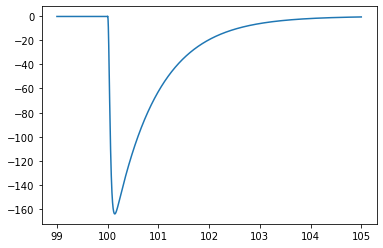

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(d.time(), d['ina.INa'])
plt.show()

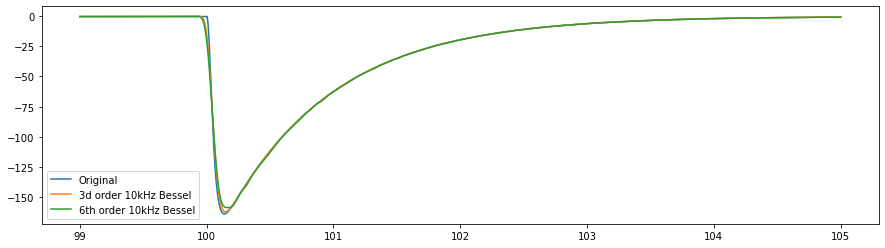

In [5]:
import numpy as np
import scipy.signal

t = d.time()
dt = np.mean(t[1:] - t[:-1])   # In ms
f = 1 / dt     # Sampling frequency, in kHz
w = 10         # Cut-off frequency, in kHz

def low_pass(data, w, f, n=3):
    """ Apply a Bessel low-pass filter with cut-off w (in Hz). """
    w = w / (f / 2)
    b, a = scipy.signal.bessel(n, w, btype='lowpass')
    return scipy.signal.filtfilt(b, a, data)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, d['ina.INa'], label='Original')
ax.plot(t, low_pass(d['ina.INa'], 10, f, 3), label='3d order 10kHz Bessel')
ax.plot(t, low_pass(d['ina.INa'], 10, f, 6), label='6th order 10kHz Bessel')
ax.legend()
plt.show()

For this fast current, the filtering does seem to have a notable effect.
It's also worth noting that, in the published EPC-9 design, the $R_s$ compensation uses a signal that has been passed through this filter.

For now, we will not include the filter in our model.

## The final model

The final model schematic is shown in Figure 3.

<img src="resources/patch-comp-5-full.png" style="margin:auto" />

_**Figure 5**: The full model with compensation._

\begin{align}
C1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
C2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} + C_f\dot{V}_o  - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + (C_p^* + C_m^*) \dot{V}_\text{ref}
\end{align}

\begin{align}
C3. && \tau_a \dot{V}_o = V_\text{ref} - V_p
\end{align}

\begin{align}
C4. && R_f I_\text{obs} = V_o - V_\text{ref}
\end{align}

\begin{align}
C5. && \tau_\text{sum} \dot{V}_\text{ref} = V_c + \alpha R_s^*I_\text{obs} - V_\text{ref}
\end{align}

### Simulations

As before, we can code this up in Myokit and simulate a voltage step:

In [1]:
m = myokit.parse_model('''
[[model]]
cell.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Vr = -80

[engine]
time = 0 [ms]
    in [ms]
    bind time

[cell]
use amp.Rs, amp.Vp
use amp.E_off, amp.E_leak, amp.R_leak
Cm = 20 [pF]
    in [pF]
    desc: The cell capacitance
I = 0 [pA]
    in [pA]
    desc: The native transmembrane current

# Equation 1
dot(Vm) = ((Vp + E_off - Vm) / Rs - (Vm - E_leak) / R_leak - I) / Cm
    in [mV]
    desc: The membrane potential.

[amp]
use cell.Vm
Vc = -20 [mV]
    in [mV]
    desc: The command potential, i.e. the intended voltage clamp potential.
E_off = 0 [mV]
    in [mV]
    desc: The error in the voltage offset zeroing.
Rs = 0.01 [GOhm]
    in [GOhm]
    desc: The series (or access) resistance. Note that this is in GOhm.
Rs_est = 0.009 [GOhm]
    in [GOhm]
    desc: The estimated Rs, used in Rs compensation.
alpha = 0.7
    desc: The applied fraction of Rs compensation.
Rf = 0.025 [GOhm]
    in [GOhm]
    desc: The used feedback resistance. Depends on the amplifier and its gain settings.
Cf = 0.3 [pF]
    in [pF]
    desc: The stray or feedback capacitance. Depends on the amplifier and its gain settings.
Cp = 4.5 [pF]
    in [pF]
    desc: The true pipette capacitance.
Cp_est = 4.2 [pF]
    in [pF]
    desc: The estimated pipette capacitance, used in C-fast compensation.
Cm_est = 103 [pF]
    in [pF]
    desc: The estimated cell capacitance, used in C-slow compensation.
tau_amp = 50e-6 [ms]
    in [ms]
    desc: The time-constant of the measuring op-amp.
tau_sum = 40e-3 [ms]
    in [ms]
    desc: The time-constant of the summing op-amp used in Rs compensation.
E_leak = 0 [mV]
    in [mV]
    desc: The reversal potential of the leak current.
R_leak = 1 [GOhm]
    desc: The seal resistance. Note that this is in GOhm.
    in [GOhm]

# Equation 2
dot(Vp) = ((Vo - Vp) / Rf + Cf * dot(Vo) - (Vp + E_off - Vm) / Rs + (Cp_est + Cm_est) * dot(Vr)) / (Cf + Cp)
    in [mV]
    desc: Pipette voltage (before the voltage drop over the series resistance).

# Equation 3
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
    desc: The voltage at the measuring op-amp output

# Equation 4
I_obs = (Vo - Vr) / Rf
    in [pA]
    desc: The reported current.
    
# Equation 5
dot(Vr) = (Vc + alpha * Rs_est * I_obs - Vr) / tau_sum
    in [mV]
    desc: The reference potential, i.e. the command potential with series resistance compensation added.
''')
m.check_units(myokit.UNIT_STRICT)

NameError: name 'myokit' is not defined

In [2]:
s = myokit.Simulation(m)
d = s.run(10)

NameError: name 'myokit' is not defined

In [3]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.set_ylabel('Vm (mV)')
kw = dict(color='#aaa', ls='--')
ax.axhline(m.get('cell.Vm').initial_value().eval(), label='Vm(t=0)', **kw)
ax.axhline(m.get('amp.Vc').eval(), label='Vc', **kw)
ax.plot(d.time(), d['cell.Vm'])

ax = fig.add_subplot(2, 2, 2)
ax.set_ylabel('Vo (mV)')
ax.plot(d.time(), d['amp.Vo'])
ins = ax.inset_axes((0.3, 0.15, 0.65, 0.55))
ins.set_xlabel('Time (ms)')
ins.set_ylabel('Vo (mV)')
ins.plot(d.time(), d['amp.Vo'])
ins.set_xlim(-0.001, 0.02)
ins.set_ylim(-400, -50)

ax = fig.add_subplot(2, 2, 3)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vp (mV)')
ax.plot(d.time(), d['amp.Vp'])
ins = ax.inset_axes((0.3, 0.15, 0.65, 0.55))
ins.set_xlabel('Time (ms)')
ins.set_ylabel('Vp (mV)')
ins.plot(d.time(), d['amp.Vp'])
ins.set_xlim(-0.001, 0.02)
ins.set_ylim(-85, -65)

ax = fig.add_subplot(2, 2, 4)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Recorded I (pA)')
ax.plot(d.time(), d['amp.I_obs'])
ins = ax.inset_axes((0.3, 0.15, 0.65, 0.55))
ins.set_xlabel('Time (ms)')
ins.set_ylabel('Recorded I (pA)')
ins.plot(d.time(), d['amp.I_obs'])
ins.set_xlim(-0.001, 0.02)

plt.show()

NameError: name 'plt' is not defined

This shows some pretty interesting behaviour: 

## Simulations

## Conclusion